# Модель предсказания массы морских черепах

Решаемая задача: разработать надёжную модель линейной регрессии, которая будет использовать габариты и другие данные от TurtleCV для предсказания массы черепах.

## 1.  Постановка задачи машинного обучения

- Необходимо решить задачу регрессии
- Целевая переменная: weight (вес черепахи)
- Метрики качества модели, которые будут использоваться: MAE, MSE (RMSE), MAPE, R-squared. В качестве основной будем использовать MAE
- Модель можно считать успешной и рекомендовать к внедрению, если и на тестовой выборке метрика MAE будет не больше 5 килограмм

## 2. Подключение и настройка библиотек

In [305]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

## 3. Загрузка датасета

In [ ]:
df = pd.read_csv('turtles.csv', sep='\t', decimal=',')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   8861 non-null   int64  
 1   binomial_name        8812 non-null   object 
 2   registration number  8832 non-null   object 
 3   shell_length         8774 non-null   float64
 4   shell_width          8861 non-null   int64  
 5   head_length          8715 non-null   float64
 6   head_width           8715 non-null   float64
 7   flipper_length_1     8861 non-null   int64  
 8   flipper_width_1      8861 non-null   int64  
 9   flipper_length_2     8861 non-null   int64  
 10  flipper_width_2      8861 non-null   int64  
 11  flipper_length_3     8760 non-null   float64
 12  flipper_width_3      8760 non-null   float64
 13  flipper_length_4     8760 non-null   float64
 14  flipper_width_4      8760 non-null   float64
 15  circle_count         8861 non-null   i

## 4. Исследовательский анализ данных

Отбор записей по виду: Chelonia mydas

In [307]:
print(df['binomial_name'].unique())

df['binomial_name'] = df['binomial_name'].str.lower()

df = df[df['binomial_name'] == 'chelonia mydas']

df.head()

['Caretta caretta' 'Lepidochelys olivacea' 'LEPIDOCHELYS OLIVACEA'
 'Lepidochelys Olivacea' 'lepidochelys olivacea' 'Chelonia mydas'
 'ERETMOCHELYS IMBRICATA' 'Eretmochelys imbricata' 'Dermochelys coriacea'
 'caretta caretta' 'CARETTA CARETTA' 'chelonia mydas' 'Chelonia Mydas'
 'CHELONIA MYDAS' 'Dermochelys Coriacea' 'eretmochelys imbricata' nan
 'Caretta Caretta' 'lepidochelys kempii' 'Lepidochelys kempii'
 'Eretmochelys Imbricata' 'dermochelys coriacea' 'Lepidochelys Kempii'
 'DERMOCHELYS CORIACEA']


,id,binomial_name,registration number,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,measure_count,shell_crack,timestamp,weight
8,25241,chelonia mydas,0d05dca974d9f624d9c9f8e38817f827,742.0,652,118.0,147.0,411,386,507,389,414.0,368.0,311.0,325.0,66,4.0,1.0,1751228603,56.352
11,20099,chelonia mydas,36e7d3b61a0d557e45ad4b39bb2ec512,1336.0,1318,207.0,248.0,845,704,661,768,587.0,686.0,661.0,585.0,111,2.0,5.0,1699913950,154.074
16,18213,chelonia mydas,cbb98eb064c1dcefd1a009b21656500f,1010.0,926,216.0,156.0,562,488,529,432,467.0,434.0,553.0,463.0,76,1.0,NaN,1680303901,87.695
20,20656,chelonia mydas,0da9da7f4ed73816b8967c7fe87fc4f5,703.0,606,NaN,NaN,355,382,411,340,302.0,355.0,314.0,283.0,62,3.0,1.0,1705325532,51.182
21,20839,chelonia mydas,8c20d754391001ef4cda77701123f4bc,982.0,940,187.0,157.0,518,557,545,463,497.0,511.0,541.0,479.0,103,2.0,NaN,1707227368,92.707


Признаки, которые стоит удалить: 
- id - модель может начать запоминать их вместо общих закономерностей, что приведет к переобучению
- binomial_name - все черепахи в выборке одного вида 
- registration number - уникальный номер также может привести к переобучению
- measure_count, timestamp - признаки, которые не влияют на вес черепахи

In [308]:
df = df.drop(columns=['id', 'binomial_name', 'registration number', 'measure_count', 'timestamp'])

In [309]:
temp = df.copy() 
len(temp)

2829

Обработка пропусков

In [310]:
def show_missing_stats(df):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': df.isna().sum(),
        'Доля пропусков': df.isna().mean() * 100
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    return missing_stats.style.format({'Доля пропусков': '{:.2f}'}).background_gradient(cmap='coolwarm')

show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
shell_length,35,1.24
head_length,39,1.38
head_width,39,1.38
flipper_length_3,31,1.10
flipper_width_3,31,1.10
flipper_length_4,31,1.10
flipper_width_4,31,1.10
shell_crack,2152,76.07
weight,3,0.11


Значения, которые будут обработаны:
- Целевая переменная weight имеет 3 пропущенные строки, которые бесполезны для обучения, поэтому будут удалены
- shell_crack имеет ~76% пропусков, при заполнении пропусков появится слишком большое число синтетических данных, что добавит шум при обучении
- Остальные признаки имеют небольшое число пропусков, которыми можно пренебречь. Заполнение данных медианой или средним будет некорректно, т.к., к примеру, малые особи могут получить нехарактерно большие для них значения, что приведёт к шуму в данных.

In [311]:
df = df.drop(columns='shell_crack', axis=1)

df = df.dropna()

show_missing_stats(df)

'Пропусков в данных нет'

Убираем явные дубликаты, поскольку их наличие может исказить результаты анализа и привести к переобучению. Поиска неполных дубликатов не будет, т.к остались только признаки с числовыми значения

In [312]:
print('Число явных дубликатов:', df.duplicated().sum())

df = df.drop_duplicates()

Число явных дубликатов: 328


In [313]:
df.describe()

,shell_length,shell_width,head_length,head_width,flipper_length_1,flipper_width_1,flipper_length_2,flipper_width_2,flipper_length_3,flipper_width_3,flipper_length_4,flipper_width_4,circle_count,weight
count,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,1048.943239,946.114357,169.601419,183.053005,612.154424,549.551336,611.876461,550.731636,487.274624,440.653172,489.369783,441.166945,80.904007,96.051661
std,574.727627,514.994624,41.295475,45.087946,141.961177,131.515230,138.171854,130.765606,110.172469,105.235199,112.254956,104.316087,16.186181,34.988126
min,645.000000,564.000000,87.000000,96.000000,339.000000,245.000000,327.000000,276.000000,282.000000,231.000000,254.000000,243.000000,29.000000,0.000000
25%,837.000000,755.000000,138.000000,148.000000,502.000000,450.000000,505.000000,449.000000,400.000000,357.000000,400.000000,360.000000,70.000000,67.538750
50%,980.500000,890.000000,163.000000,176.000000,588.000000,528.000000,591.000000,533.500000,473.000000,426.000000,473.000000,423.000000,80.000000,88.178500
75%,1170.500000,1055.000000,195.000000,212.000000,702.000000,631.000000,703.000000,635.250000,558.000000,511.000000,563.000000,509.000000,91.000000,117.542250
max,12840.000000,11550.000000,328.000000,364.000000,1147.000000,1072.000000,1049.000000,997.000000,934.000000,837.000000,877.000000,806.000000,141.000000,199.961000


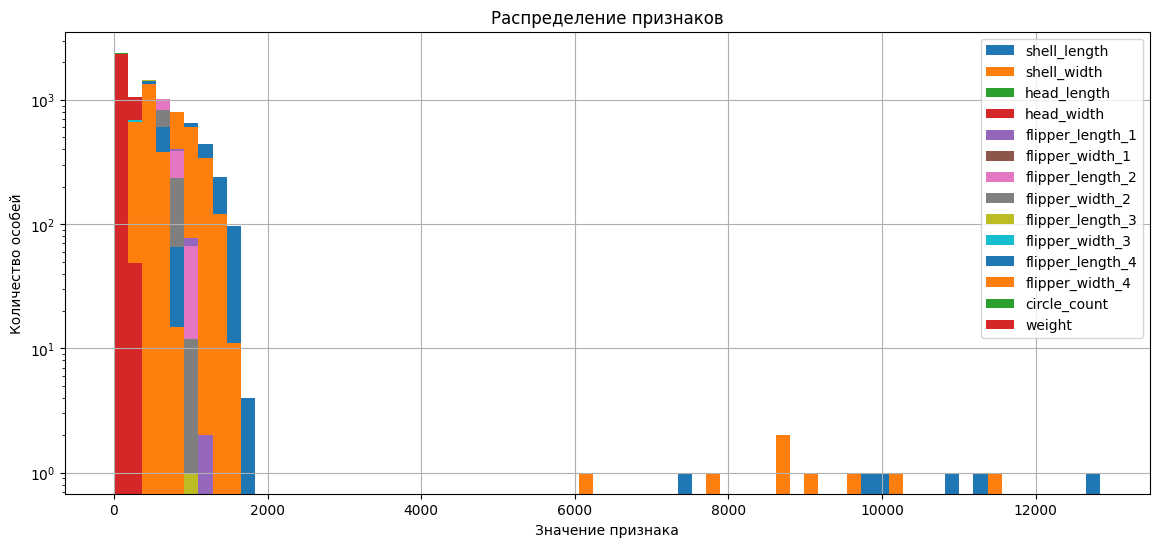

In [314]:
df.plot(
    kind='hist',
    bins=70,
    grid=True,
    figsize=(14, 6),
    title='Распределение признаков',
)


plt.xlabel('Значение признака')
plt.ylabel('Количество особей')
plt.yscale('log')

plt.show()

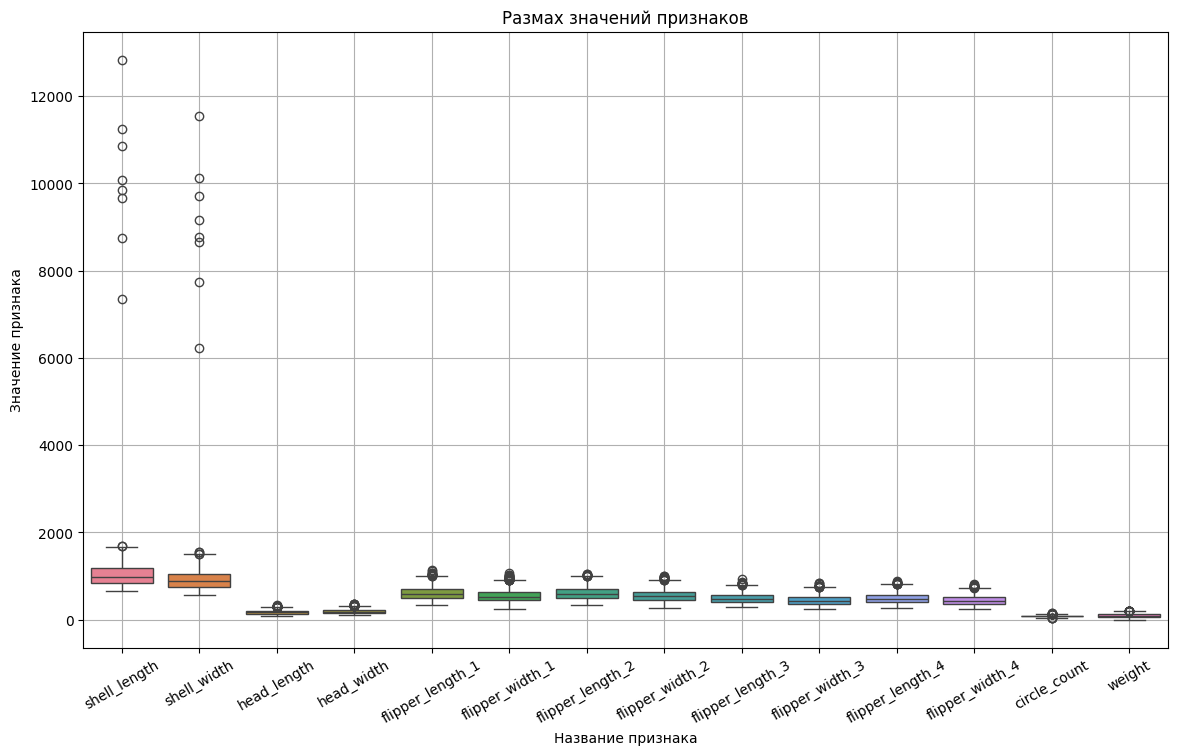

In [315]:
def create_df_boxplot(df):
    plt.figure(figsize=(14, 8))

    sns.boxplot(
        data=df
    )

    plt.title('Размах значений признаков')
    plt.xlabel('Название признака')
    plt.ylabel('Значение признака')

    plt.grid()
    plt.xticks(rotation=30)

    plt.show()

create_df_boxplot(df)

Из диаграмм следует, что признаки shell_length и shell_width имеют выбросы, которые произошли из-за домножения на 10 волонтером. Также в датасете есть 3 черепахи со значением веса 0, что говорит об ошибке, поэтому такие данные стоит исключить.

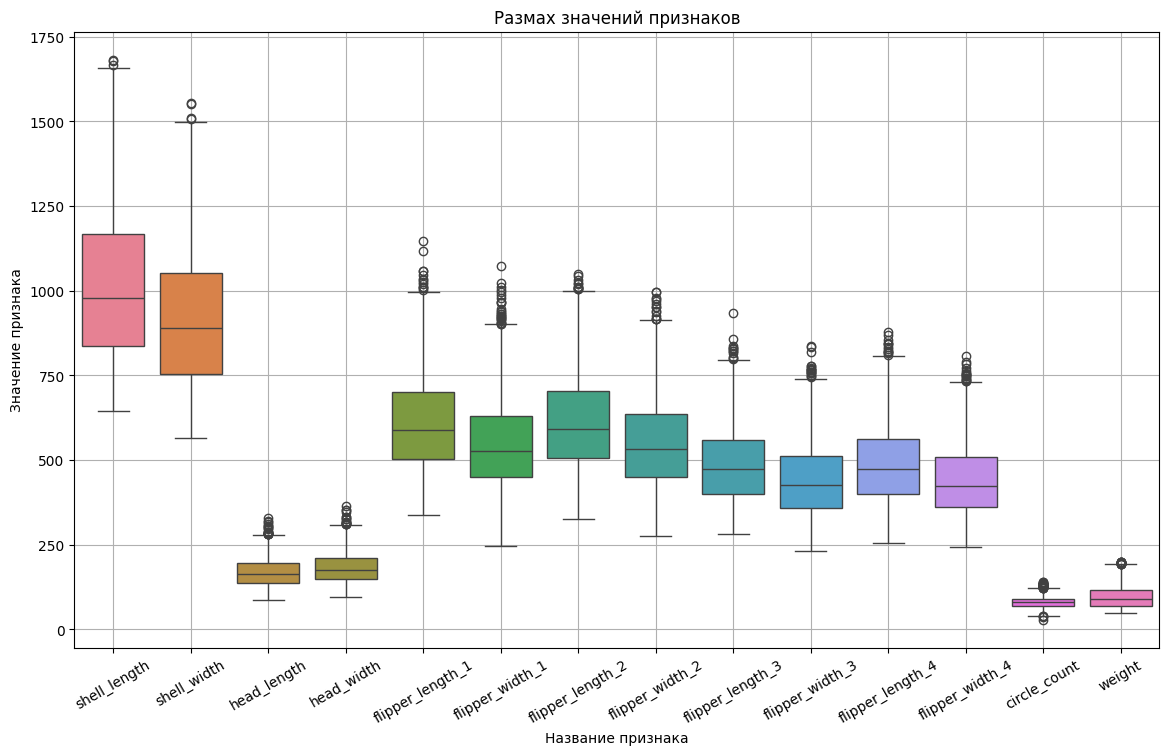

In [316]:
df['shell_length'] = np.where(
    df['shell_length'] > 2000,
    df['shell_length'] / 10,
    df['shell_length']
)

df['shell_width'] = np.where(
    df['shell_width'] > 2000,
    df['shell_width'] / 10,
    df['shell_width']
)

df = df[df['weight'] > 0]

create_df_boxplot(df)

In [317]:
before, after = len(temp), len(df)
print(" Было строк в исходном датасете:", before,
      '\n', "Осталось строк в датасете после обработки:", after,
      '\n', "Удалено строк в датасете после обработки:", before-after,
      '\n', f"Процент потерь: {(before-after)/before*100:.2f}%")

 Было строк в исходном датасете: 2829 
 Осталось строк в датасете после обработки: 2393 
 Удалено строк в датасете после обработки: 436 
 Процент потерь: 15.41%


Проверка корреляции между признаками

In [318]:
def create_heatmap(corr, title, ax=None):
    if ax is None:
        plt.figure(figsize=(6, 5))
        ax = plt.gca()

    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=.5,
        cbar=False,
        ax=ax
    )
    
    ax.set_title(title)
    
    if len(ax.figure.get_axes()) == 1:
        plt.show()

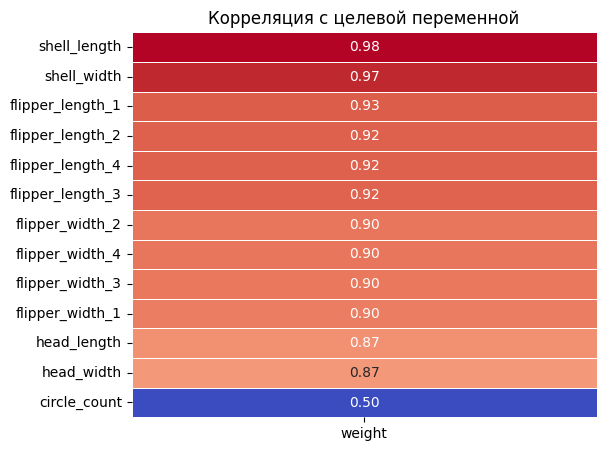

In [319]:
corr_matrix = df.corr()
target_correlation = corr_matrix[corr_matrix.index != 'weight'][['weight']].sort_values(by='weight', ascending=False)

create_heatmap(target_correlation, title='Корреляция с целевой переменной')

Большинство признаков сильно коррелируют с целевой переменной, значение больше 85%. При этом самую низкую корреляцию имеет признак circle_count - 50%, значение далеко от 0, поэтому считать это шумом нельзя.

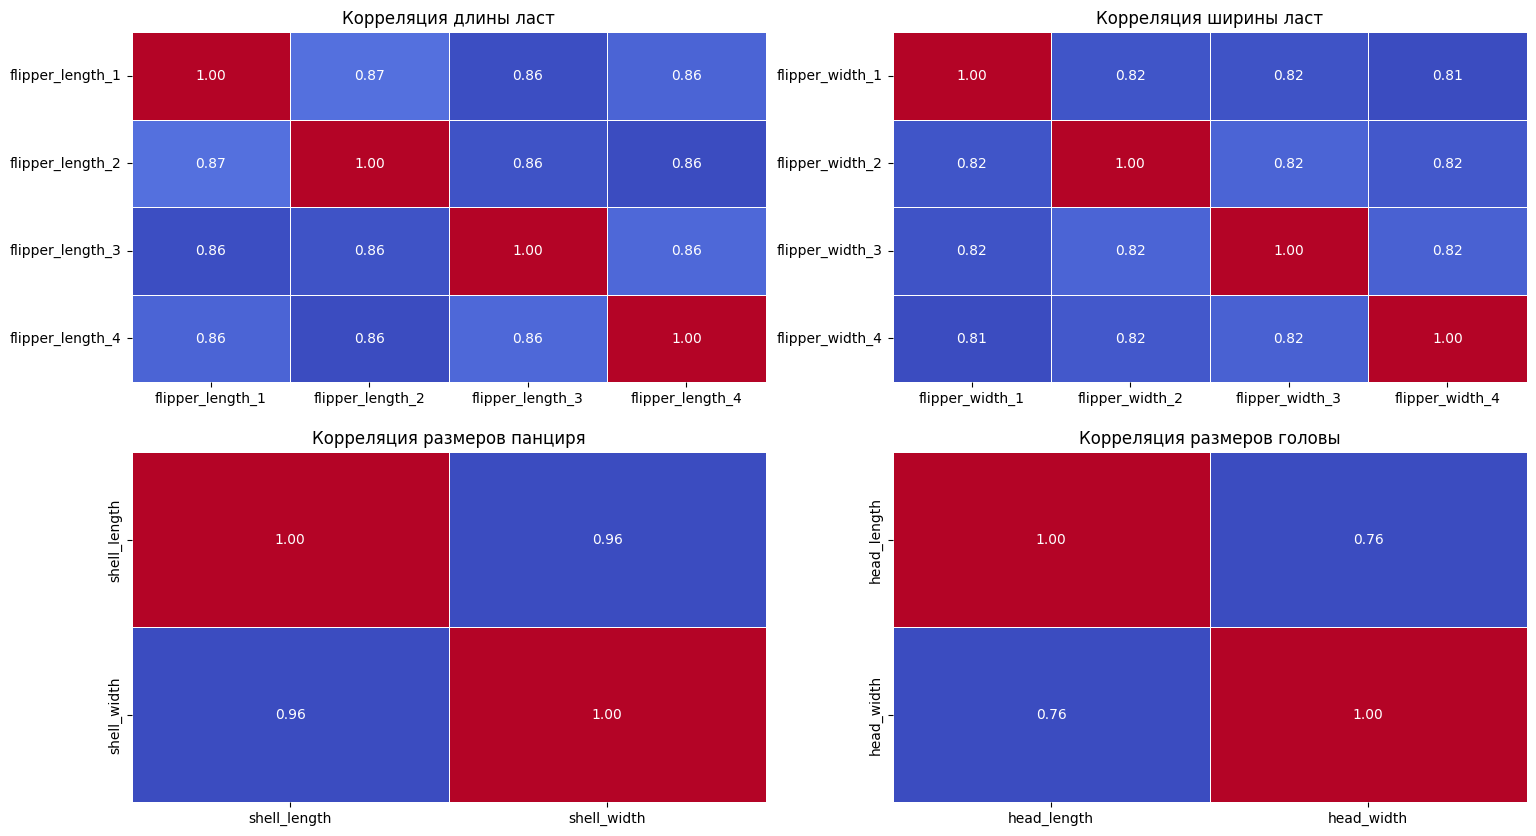

In [320]:
flipper_length_corr = df[['flipper_length_1', 'flipper_length_2', 'flipper_length_3', 'flipper_length_4']].corr()
flipper_width_corr = df[['flipper_width_1', 'flipper_width_2', 'flipper_width_3', 'flipper_width_4']].corr()
shell_corr = df[['shell_length', 'shell_width']].corr()
head_corr = df[['head_length', 'head_width']].corr()

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

create_heatmap(flipper_length_corr, title='Корреляция длины ласт', ax=axes[0][0])
create_heatmap(flipper_width_corr, title='Корреляция ширины ласт', ax=axes[0][1])
create_heatmap(shell_corr, title='Корреляция размеров панциря', ax=axes[1][0])
create_heatmap(head_corr, title='Корреляция размеров головы', ax=axes[1][1])

plt.show()

Между признаками выше имеется сильная корреляция, т.к. в природе данные значения пропорциональны и увеличение или уменьшение одного приведёт к изменению размеров другого, что скажется на обучении модели и приведёт к мультиколлинеарности. Поэтому, по части признаков для начала нужно найти среднее, а после объединить в показатель площади. Чем больше площадь, тем больше вес черепахи и наоборот.

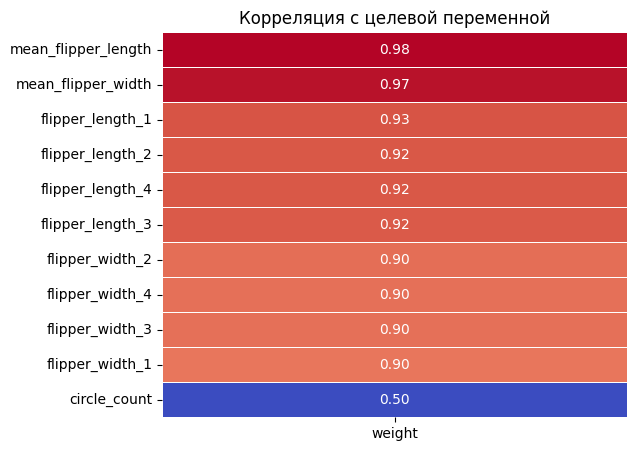

In [321]:
df = df.copy()

df['mean_flipper_length'] = df[['flipper_length_1', 'flipper_length_2', 'flipper_length_3', 'flipper_length_4']].mean(axis=1)
df['mean_flipper_width'] = df[['flipper_width_1', 'flipper_width_2', 'flipper_width_3', 'flipper_width_4']].mean(axis=1)

cols_to_exclude = ['shell_length', 'shell_width', 'head_length', 'head_width']
corr_matrix = df.drop(columns=cols_to_exclude).corr()
target_correlation = corr_matrix[corr_matrix.index != 'weight'][['weight']].sort_values(by='weight', ascending=False)

create_heatmap(target_correlation, title='Корреляция с целевой переменной')

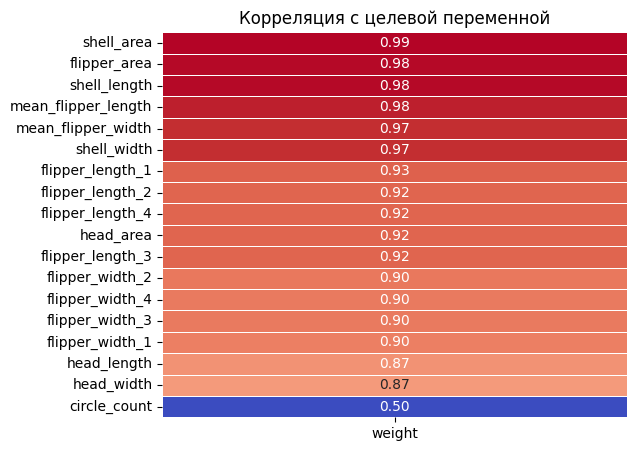

In [322]:
df = df.copy() 

df['flipper_area'] = df['mean_flipper_length'] * df['mean_flipper_width']
df['shell_area'] = df['shell_length'] * df['shell_width']
df['head_area'] = df['head_length'] * df['head_width']

corr_matrix = df.corr()
target_correlation = corr_matrix[corr_matrix.index != 'weight'][['weight']].sort_values(by='weight', ascending=False)

create_heatmap(target_correlation, title='Корреляция с целевой переменной')

df = df[['flipper_area', 'shell_area', 'head_area', 'circle_count', 'weight']]

Корреляция усилилась, значит предположение оказалось верным. Объединение создало "супер-признаки".

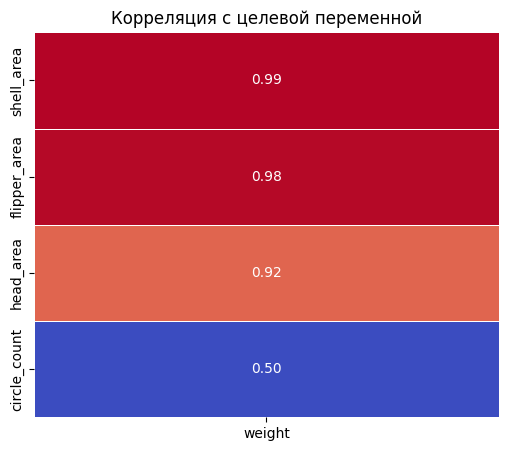

In [323]:
corr_matrix = df.corr()
target_correlation = corr_matrix[corr_matrix.index != 'weight'][['weight']].sort_values(by='weight', ascending=False)

create_heatmap(target_correlation, title='Корреляция с целевой переменной')

## 5. Предобработка данных

In [324]:
X = df.drop(columns='weight')
y = df['weight']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, shuffle=True, random_state=42)

In [325]:
def scale_data(X_train, X_val, X_test, method='standard'):
    if method == 'standard':
        mean = X_train.mean()
        std = X_train.std()
    
        X_train_scaled = (X_train - mean) / std
        X_val_scaled = (X_val - mean) / std
        X_test_scaled = (X_test - mean) / std
    elif method == 'minmax':
        min_val = X_train.min()
        max_val = X_train.max()

        X_train_scaled = (X_train - min_val) / (max_val - min_val)
        X_val_scaled = (X_val - min_val) / (max_val - min_val)
        X_test_scaled = (X_test - min_val) / (max_val - min_val)
    else:
        return ValueError("Неверный метод масштабирования")
    
    return X_train_scaled, X_val_scaled, X_test_scaled

In [326]:
X_train_stand, X_val_stand, X_test_stand = scale_data(X_train, X_val, X_test, method='standard')
X_train_norm, X_val_norm, X_test_norm = scale_data(X_train, X_val, X_test, method='minmax')

## 6. Обучение моделей

In [327]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, mape, r2

In [328]:
results_list = []

def concat_data(
    results_list,
    model,
    mae,
    mse,
    rmse,
    mape,
    r2,
    s_method='No scaling', 
    loss='No loss', 
    alpha='No alpha', 
    learning_rate='No learning rate', 
    eta='No eta', 
    tol='No tol'
):
    results_list.append({
        'Model': model,          
        'MAE': round(mae, 2), 
        'MSE': round(mse, 2), 
        'RMSE': round(rmse, 2), 
        'MAPE': f'{round(mape * 100, 2)}%',
        'R2': f'{round(r2 * 100, 2)}%',
        'Scale Method': s_method, 
        'Loss': loss,
        'Alpha': alpha,
        'Learning rate': learning_rate,
        'Eta': eta,
        'Tol': tol
    })

    return results_list

In [329]:
dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_val)

results_list = concat_data(results_list, 'Dummy', *calculate_metrics(y_val, y_pred_dummy))

pd.DataFrame(results_list)

,Model,MAE,MSE,RMSE,MAPE,R2,Scale Method,Loss,Alpha,Learning rate,Eta,Tol
0,Dummy,29.11,1215.58,34.87,33.44%,-0.06%,No scaling,No loss,No alpha,No learning rate,No eta,No tol


In [330]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_val)

results_list = concat_data(results_list, 'Linear regression', *calculate_metrics(y_val, y_pred))

data = [
    {'train': X_train, 'val': X_val, 's_method': 'No scaling'}, 
    {'train': X_train_stand, 'val': X_val_stand, 's_method': 'standard'}, 
    {'train': X_train_norm, 'val': X_val_norm, 's_method': 'minmax'}
]
losses         = ['squared_error', 'huber']
alphas         = [0.001, 0.01, 0.1]
learning_rates = ['adaptive', 'optimal']
etas           = [0.01, 0.1]
tols           = [1e-5, 1e-3]

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42)
    redge = Ridge(alpha=alpha, random_state=42)

    for el in data:
        train, val, s_method = el['train'], el['val'], el['s_method']
        
        lasso.fit(train, y_train)
        y_pred = lasso.predict(val)
        results_list = concat_data(results_list, 'Lasso', *calculate_metrics(y_val, y_pred), s_method, alpha=alpha)

        redge.fit(el['train'], y_train)
        y_pred = redge.predict(el['val'])
        results_list = concat_data(results_list, 'Ridge', *calculate_metrics(y_val, y_pred), s_method, alpha=alpha)

for loss in losses:
    for alpha in alphas:
        for learning_rate in learning_rates:
            for eta in etas:
                for tol in tols:
                    sgd = SGDRegressor(loss=loss, alpha=alpha, learning_rate=learning_rate, eta0=eta, tol=tol, random_state=42)
                    
                    for el in data:
                        train, val, s_method = el['train'], el['val'], el['s_method']
                        
                        if el['s_method'] == 'No scaling':
                            continue
                        
                        sgd.fit(el['train'], y_train)
                        y_pred = sgd.predict(el['val'])
                        results_list = concat_data(results_list, 'SGD regressor', *calculate_metrics(y_val, y_pred), s_method, loss, alpha, learning_rate, eta, tol)

df_results = pd.DataFrame(results_list)

/Users/katsay/develop/ML/venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/katsay/develop/ML/venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/katsay/develop/ML/venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/katsay/develop/ML/venv/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warning

## 7. Сравнение моделей на валидационной выборке

In [331]:
best_results = df_results.sort_values(by='MAE', ascending=True)

best_results.head(5)

,Model,MAE,MSE,RMSE,MAPE,R2,Scale Method,Loss,Alpha,Learning rate,Eta,Tol
30,SGD regressor,3.11,16.89,4.11,3.27%,98.61%,standard,squared_error,0.001,optimal,0.01,0.001
32,SGD regressor,3.11,16.89,4.11,3.27%,98.61%,standard,squared_error,0.001,optimal,0.1,0.00001
34,SGD regressor,3.11,16.89,4.11,3.27%,98.61%,standard,squared_error,0.001,optimal,0.1,0.001
28,SGD regressor,3.11,16.89,4.11,3.27%,98.61%,standard,squared_error,0.001,optimal,0.01,0.00001
13,Ridge,3.15,17.03,4.13,3.32%,98.6%,minmax,No loss,0.01,No learning rate,No eta,No tol


В результате обучения моделей получилось существенно улучшить результат. Базовая модель имеет ошибку 29.11кг (MAE), лучшая обученная модель имеет ошибку 3.11кг (MAE).

Модель с самым точным результатом оказалась SGD regressor с опредленным набором параметров. Остальные модели (LinearRegression, Ridge, Lasso) показали почти абсолютно такие же результаты (разница в 1 сотую по показателю R^2 и 4 сотые по показателю MAE).

## 8. Проверка лучшей модели на тестовой выборке

In [332]:
# Зная параметры лучшей модели остаётся обучить только её и протестировать на тестовой выборке

sgd = SGDRegressor(loss='squared_error', alpha=0.001, learning_rate='optimal', eta0=0.1, tol=0.001, random_state=42)
sgd.fit(X_train_stand, y_train)

y_pred = sgd.predict(X_test_stand)
mae, mse, rmse, mape, r2 = calculate_metrics(y_test, y_pred)

print(
    " EMA:", round(mae, 2), "\n",
    "MSE:", round(mse, 2), "\n",
    "RMSE:", round(rmse, 2), "\n",
    "MAPE:", f'{round(mape * 100, 2)}%', "\n",
    "R2:", f'{round(r2 * 100, 2)}%',
)

 EMA: 3.15 
 MSE: 17.45 
 RMSE: 4.18 
 MAPE: 3.32% 
 R2: 98.57%


В результате предсказания на тестовой выборке можно сказать, что модель обучилась корректно и показывает отличный результат как на данных валидации, так и на тестовых данных, что говорит о том, что модель правильно определила закономерность для определения целевой переменной.

Требования заказчика выполнены. Результат оказался лучше, чем в поставленной задаче. Вместо ошибки в ~5кг, получилось добиться расхождения всего в 3.15кг. Модель ошибается ~3,3% случаях, что является хорошим результатом. Модель можно рекомендовать к внедрению.

## 9. Оценка важности признаков

In [333]:
importance_df = pd.DataFrame({
    'Признак': sgd.feature_names_in_,
    'Значение веса': np.abs(sgd.coef_)
})

importance_df = importance_df.sort_values(by='Значение веса', ascending=False)

importance_df.style.format({'Значение веса': '{:.2f}'}).background_gradient(cmap='coolwarm')

,Признак,Значение веса
1,shell_area,18.57
0,flipper_area,13.89
2,head_area,2.63
3,circle_count,0.81


Для модели самыми важными параметрами стали: размер панциря (18,57) и ласт (13,89). После идет размер головы (2,63) и самое маленькое значение веса имеет признак: количество колец на панцире (0,81).
Согласен с результатами модели. Действительно, данные признаки в природе оказывают наибольшее влияние на итоговый вес особи.

## 10. Функция для прогнозирования веса черепахи

In [334]:
def predict_turtle_weight(turtle_data, intercept, importance_df, X_train):
    if turtle_data.get('binomial_name', '').lower() != 'chelonia mydas':
        raise ValueError('Вид черепахи не соответствует Chelonia Mydas')
    
    flipper_length_features = ['flipper_length_1', 'flipper_length_2', 'flipper_length_3', 'flipper_length_4']
    flipper_width_features = ['flipper_width_1', 'flipper_width_2', 'flipper_width_3', 'flipper_width_4']
    necessary_features = ['shell_length', 'shell_width', 'head_length', 'head_width', *flipper_length_features, *flipper_width_features, 'circle_count']
    for feature in necessary_features:
        if feature not in turtle_data or turtle_data[feature] is None:
             raise ValueError(f'Важный параметр не указан: {feature}')

        if not isinstance(turtle_data[feature], (int, float)):
             raise ValueError(f'Параметр {feature} должен быть числом, а не {type(turtle_data[feature])}')
    
    flipper_length_sum = sum(turtle_data[f] for f in flipper_length_features)
    flipper_width_sum = sum(turtle_data[f] for f in flipper_width_features)
    
    mean_flipper_length = flipper_length_sum / 4
    mean_flipper_width = flipper_width_sum / 4
    
    features_values = {
        'flipper_area': mean_flipper_length * mean_flipper_width,
        'shell_area': turtle_data['shell_length'] * turtle_data['shell_width'],
        'head_area': turtle_data['head_length'] * turtle_data['head_width'],
        'circle_count': turtle_data['circle_count']
    }

    total_weight = intercept[0]
    for feature_name, value in features_values.items():
        mean = X_train[feature_name].mean()
        std = X_train[feature_name].std()
        
        try:
            weight = importance_df.loc[importance_df['Признак'] == feature_name, 'Значение веса'].values[0]
        except IndexError:
            raise ValueError(f"Вес для признака '{feature_name}' не найден в таблице важности")
        
        total_weight += weight * (value - mean) / std

    return round(total_weight, 2)

    

In [335]:
test_turtle_data = {
    'id': 1,
    'binomial_name': 'chelonia mydas', 
    'registration number': '0d05dca974d9f624d9c9f8e38817f900',
    'shell_length': 762,
    'shell_width': 662,
    'head_length': 128,
    'head_width': 157,
    'flipper_length_1': 411,
    'flipper_width_1': 386,
    'flipper_length_2': 527,
    'flipper_width_2': 399,
    'flipper_length_3': 454,
    'flipper_width_3': 378,	
    'flipper_length_4': 361,
    'flipper_width_4': 365,
    'circle_count': 69,	
    'measure_count': 4,	
    'shell_crack': 1,
    'timestamp': 1751228643
}

turtle_weight = predict_turtle_weight(test_turtle_data, sgd.intercept_, importance_df, X_train).item()
print(f'Вес черепахи: {turtle_weight}кг')

test_turtle_data = {
    'id': 1,
    'binomial_name': 'chelonia mydas', 
    'registration number': '0d05dca974d9f624d9c9f8e38817f900',
    'shell_length': 772,
    'shell_width': 672,
    'head_length': 138,
    'head_width': 167,
    'flipper_length_1': 421,
    'flipper_width_1': 396,
    'flipper_length_2': 527,
    'flipper_width_2': 409,
    'flipper_length_3': 464,
    'flipper_width_3': 388,	
    'flipper_length_4': 371,
    'flipper_width_4': 375,
    'circle_count': 79,	
    'measure_count': 4,	
    'shell_crack': 1,
    'timestamp': 1751228643
}

turtle_weight = predict_turtle_weight(test_turtle_data, sgd.intercept_, importance_df, X_train).item()
print(f'Вес черепахи: {turtle_weight}кг')

Вес черепахи: 60.58кг
Вес черепахи: 63.0кг


Результат обработки тестовых данных на новых черепах показывает, что модель правильно научилась определять закономерность и при увеличении показателей, вес также увеличивается.

## 11. Общие выводы и рекомендации по дальнейшей работе



Какие модели изучены?
- Изучены линейные модели: LinearRegression, Lasso, Ridge и SGDRegressor. Всего было обучено и проверено 116 вариаций моделей.

Какие результаты получены?
- Ошибка сократилась с 29.11 кг (базовая) до 3.15 кг на тесте. Итоговые метрики: MAE — 3.15, R2R2 — 98.57%, MAPE — 3.32%.

Рекомендуется ли итоговая модель к внедрению?
- Да. Результат превзошел требования заказчика: достигнута точность 3.15 кг при допустимом пороге в 5 кг.

Какая архитектура показала себя лучше всего?
- Лучшей стала SGDRegressor. При этом разница с остальными алгоритмами минимальна (отличия в сотых долях по MAE и R2R2).

Какие признаки наиболее важны?
- Ключевые признаки: размер панциря (коэффициент 18.57) и размер ласт (13.89). Наименьший вклад вносит количество колец.

Перспективы и предложения
- Линейный подход доказал эффективность. Рекомендуется масштабировать методику на другие виды черепах с похожей физиологией.
